In [ ]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import re
import math
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/MyDrive/Competition/"

In [ ]:
# Imports
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import tensorflow.image as tfimg

In [ ]:
ORIG_IMG_SIZE = (720,1280,3)
Y_CROP = 300
IMG_SIZE = (ORIG_IMG_SIZE[0] - Y_CROP, ORIG_IMG_SIZE[1],ORIG_IMG_SIZE[2])

In [ ]:
folders = ["IMG12", "IMG15", "IMG16", "IMG19", "IMG23", "IMG24", "IMG25", "IMG26"]

paths = []
for folder in folders:
  paths.append(root_path + folder + "/")

In [ ]:
#create ordered lists of images and states for each run

imgLists = []
stateLists = []

for i in range(len(paths)):
  imgLists.append(np.load(paths[i] + "imgList.npy"))
  for j in range(imgLists[i].size):
    imgLists[i][j] = "Image" + imgLists[i][j].partition("Image")[2]

  stateLists.append(np.load(paths[i] + "stateList.npy"))


In [ ]:
#put the image state tuples in lists 

dataLists = []

for i in range(len(paths)):
  dataLists.append([])
  for j in range(imgLists[i].size):
    dataLists[i].append((imgLists[i][j], stateLists[i][j]))

In [ ]:
#shuffle the tuples in each run 

for list in dataLists:
  np.random.shuffle(list)

In [ ]:
#normalize the data lists to have a set number of each state 

normalizedDataLists = []
numPerClass = 30

for i in range(len(paths)):
  normalizedDataLists.append([])
  stopCount = 0
  leftCount = 0
  straightCount = 0
  rightCount = 0

  for j in range(len(dataLists[i])):
    if np.array_equal(dataLists[i][j][1],np.eye(4)[0]) and stopCount < numPerClass:
      stopCount +=1
      normalizedDataLists[i].append(dataLists[i][j])
    if np.array_equal(dataLists[i][j][1],np.eye(4)[1]) and leftCount < numPerClass:
      leftCount +=1
      normalizedDataLists[i].append(dataLists[i][j])
    if np.array_equal(dataLists[i][j][1],np.eye(4)[2]) and straightCount < numPerClass:
      straightCount +=1
      normalizedDataLists[i].append(dataLists[i][j])
    if np.array_equal(dataLists[i][j][1],np.eye(4)[3]) and rightCount < numPerClass:
      rightCount +=1
      normalizedDataLists[i].append(dataLists[i][j])
  print(rightCount)
  print(len(normalizedDataLists[i]))

30
120
27
117
30
120
30
120
30
120
30
120
30
120
30
120


In [ ]:

training_set = []


for i in range(len(paths)):
  for j in range(len(normalizedDataLists[i])):
    #crop the first 300 rows (y values) out
    # Normalize X (images) dataset (need typecast because otherwise converting the ints to float64s would take up too much memory)
    img = cv2.imread(paths[i] + normalizedDataLists[i][j][0], cv2.IMREAD_UNCHANGED)[Y_CROP:]
    
    scale_percent = 50 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
      
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA).astype(np.float32)/255

    training_set.append((img, normalizedDataLists[i][j][1]))



In [ ]:
np.random.shuffle(training_set)

inputSet = np.array([data[0] for data in training_set])
outputSet = np.array([data[1] for data in training_set])





In [ ]:
stop = 0
left = 0
straight = 0
right = 0

for arr in outputSet:
  if np.array_equal(arr,np.eye(4)[0]):
    stop +=1
  if np.array_equal(arr,np.eye(4)[1]):
    left +=1
  if np.array_equal(arr,np.eye(4)[2]):
    straight +=1
  if np.array_equal(arr,np.eye(4)[3]):
    right +=1

print(stop)
print(left)
print(straight)
print(right)

240
240
240
237


### Create neural network

In [ ]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(height,width,3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (2, 2), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(512, activation='relu'))
conv_model.add(layers.Dense(4, activation='softmax'))

conv_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 208, 638, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 104, 319, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 102, 317, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 51, 158, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 157, 128)      32896     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 78, 128)     

In [ ]:
# #input and ouput shape must match shape of input and expected output shapes
# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(height,width,3)))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(512, activation='relu'))
# #softmax normalizes the output to a probability distribution over predicted output classes
# conv_model.add(layers.Dense(4, activation='softmax'))
# conv_model.summary()

In [ ]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [ ]:
history_conv = conv_model.fit(inputSet, outputSet, 
                              validation_split=0.2, 
                              epochs=80, 
                              batch_size=32)


Epoch 1/80
24/24 [==============================] - 8s 245ms/step - loss: 1.0216 - acc: 0.5556 - val_loss: 0.7356 - val_acc: 0.7500
Epoch 2/80
24/24 [==============================] - 5s 200ms/step - loss: 0.7112 - acc: 0.7020 - val_loss: 0.6812 - val_acc: 0.7552
Epoch 3/80
24/24 [==============================] - 5s 192ms/step - loss: 0.6596 - acc: 0.7216 - val_loss: 0.6654 - val_acc: 0.7604
Epoch 4/80
24/24 [==============================] - 5s 201ms/step - loss: 0.6246 - acc: 0.7438 - val_loss: 0.6539 - val_acc: 0.7240
Epoch 5/80
24/24 [==============================] - 5s 191ms/step - loss: 0.5769 - acc: 0.7765 - val_loss: 0.6572 - val_acc: 0.7396
Epoch 6/80
24/24 [==============================] - 5s 203ms/step - loss: 0.5576 - acc: 0.7922 - val_loss: 0.6295 - val_acc: 0.7812
Epoch 7/80
24/24 [==============================] - 5s 198ms/step - loss: 0.5391 - acc: 0.7830 - val_loss: 0.6361 - val_acc: 0.7604
Epoch 8/80
24/24 [==============================] - 5s 198ms/step - loss: 0.

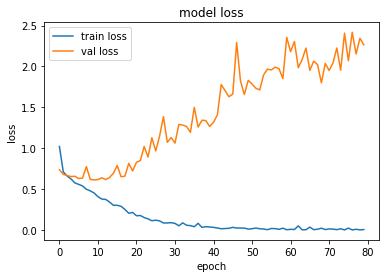

In [ ]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

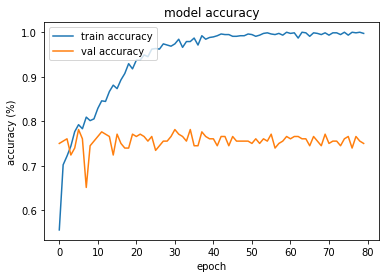

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
conv_model.save(root_path + "NN_8R30_1.h5")